In [2]:
%reset -f

In [3]:
# make sure python version is between 3.7 and 3.10
import sys
print(sys.version)

3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]


## Importing Libraries

In [4]:
#Data import
import kagglehub as kh
import sqlite3 as s3

#Data Exploring
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data PreProcessing & Modeling
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy
from collections import defaultdict
import pickle

c:\Users\saura\miniconda3\envs\proj_rec\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [ ]:
path = kh.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)
# conn = s3.connect(path+'/database.sqlite')

Path to dataset files: C:\Users\saura\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2


In [8]:
df = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

## Exploring Data

In [9]:
print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [11]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [12]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## PreProcessing Data

In [13]:
#Drop null and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [14]:
df = df[['UserId', 'ProductId', 'Score']]
df.columns = ['user_id', 'item_id', 'rating']

In [15]:
print(f"Dataset size after cleaning: {df.shape}")

df['user_id'] = df['user_id'].astype('category').cat.codes
df['item_id'] = df['item_id'].astype('category').cat.codes
df['rating'] = df['rating'].astype(float)

# Keep users with at least 50 reviews
min_reviews = 50
user_counts = df['user_id'].value_counts()
df = df[df['user_id'].isin(user_counts[user_counts >= min_reviews].index)]

# Keep products with at least 5 reviews
# item_counts = df['item_id'].value_counts()
# df = df[df['item_id'].isin(item_counts[item_counts >= min_reviews].index)]

print(f"Dataset size after filtering: {df.shape}")

Dataset size after cleaning: (568454, 3)
Dataset size after filtering: (22941, 3)


In [16]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['item_id'].nunique())

Number of unique USERS in Raw data =  267
Number of unique ITEMS in Raw data =  11313


In [17]:
# Define reader with rating scale
reader = Reader(rating_scale=(df['rating'].min(), df['rating'].max()))

# Load data into Surprise dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

## Data Visualization

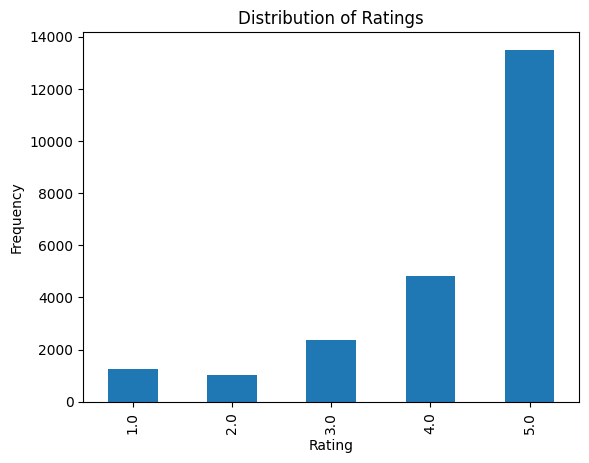

In [18]:
# Distribution of Ratings
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

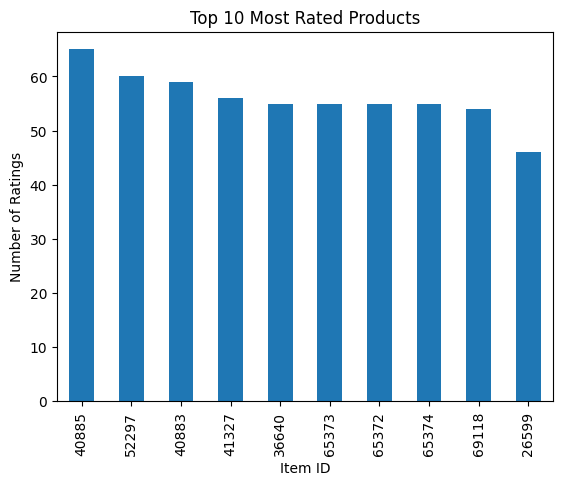

In [19]:
# Top 10 Most Rated Products
df['item_id'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Most Rated Products')
plt.xlabel('Item ID')
plt.ylabel('Number of Ratings')
plt.show()

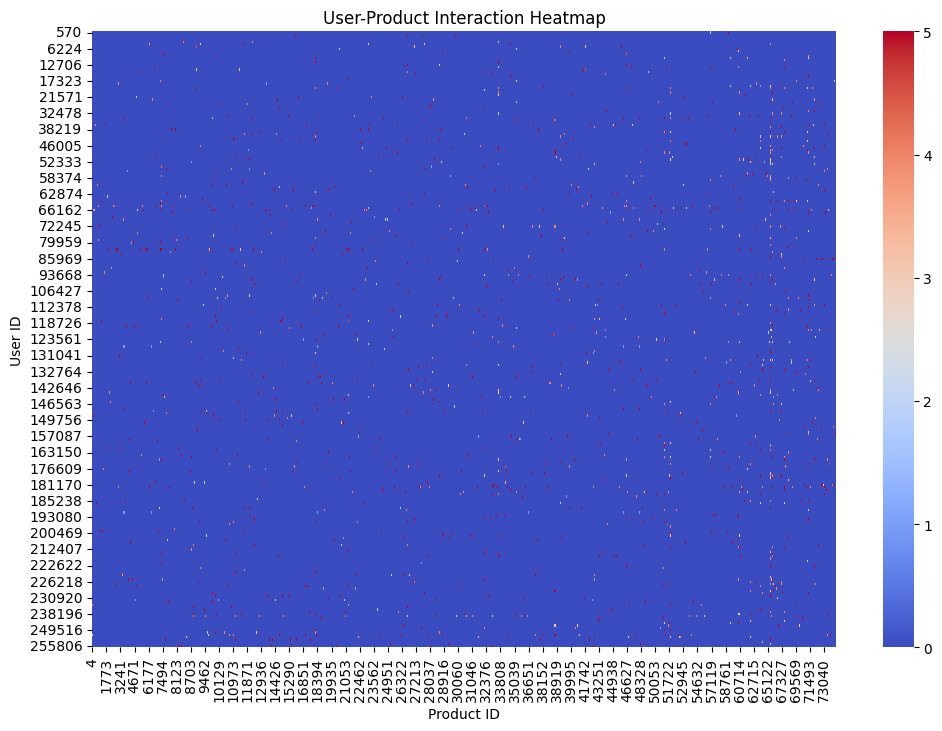

In [20]:
### 1. User-Product Interaction Heatmap ###
interaction_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_matrix, cmap="coolwarm", cbar=True)
plt.title('User-Product Interaction Heatmap')
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.show()

## Model Training

In [ ]:
# Split into train (80%) and test (20%)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
# Train SVD
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(trainset)

In [ ]:
# Make predictions on the test set
predictions = svd_model.test(testset)

# Calculate RMSE (Root Mean Square Error)
rmse = accuracy.rmse(predictions)
print(f"Test RMSE: {rmse}")

In [ ]:
def get_top_n_recommendations(model, user_id, n=5):
    all_products = df['item_id'].unique()
    predictions = [(item, model.predict(user_id, item).est) for item in all_products]
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    return top_n

# Example: Get top 5 recommendations for user 123
recommendations = get_top_n_recommendations(model, user_id=123, n=5)
print(recommendations)

In [ ]:
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

# Best model
best_model = grid_search.best_estimator['rmse']


In [ ]:
# Save the trained model
with open("./models/recommendation_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("Model saved successfully!")

In [ ]:
# Load the trained model
with open("./models/recommendation_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

print("Model loaded successfully!")